In [11]:
%config Completer.use_jedi = False
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numgp as npg
import jax.numpy as jnp
from numgp.math import cartesian
from jax.random import PRNGKey


import numpy as np
import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal

In [5]:
data = pd.read_csv("redwood.csv",index_col=0)

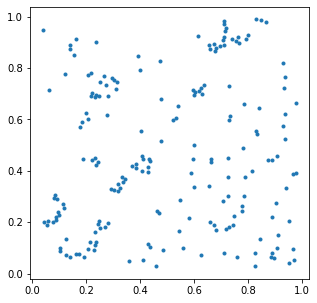

In [6]:
plt.figure(figsize=(5,5))
plt.plot(data['redwoodfull.x'], data['redwoodfull.y'], '.')

In [7]:
def bin_2d_data(x, y, bins=20):
    """
    Bins to 2D data to a regular grid.
    """
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=(bins, bins))
    xcenters = (x_edges[:-1] + x_edges[1:]) / 2
    ycenters = (y_edges[:-1] + y_edges[1:]) / 2
    
    X = [jnp.asarray(xcenters[:, None]), jnp.asarray(ycenters[:, None])]
    y = jnp.asarray(hist.reshape(-1))
    Xc = cartesian(X)
    return X, Xc, y

def show_data(ax, X, y, title='2D data'):
    im = ax.imshow(y, origin='lower', 
                   extent=[X[0][0][0], X[0][-1][0], X[1][0][0], X[1][-1][0]])
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    

def dot_plot(ax, Xc, y, cmap = "Reds"):
    norm = mpl.colors.Normalize(vmin=0, vmax=10)
    im = ax.scatter(Xc[:, 0], Xc[:, 1], s=90, c=y, marker="o", norm=norm, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

In [8]:
X, Xc, y = bin_2d_data(data['redwoodfull.x'].values, data['redwoodfull.y'].values)

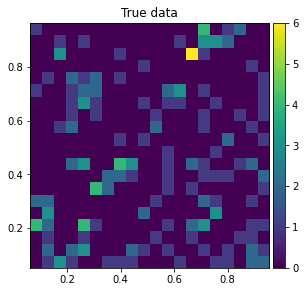

In [10]:
fig = plt.figure(figsize=(5, 4.5))
ax = plt.gca()
show_data(ax, X, y.reshape(20, -1).T, title='True data')

In [12]:
def model_fixed_lengthscale(X, y, Xnew, lengh_scale):
    cov_func_x = npg.cov.ExpQuad(1, ls=lengh_scale)
    cov_func_y = npg.cov.ExpQuad(1, ls=lengh_scale)
    
    gp = npg.gp.LatentKron('f', cov_funcs=[cov_func_x, cov_func_y])
    f = gp.prior(Xs=X)
    _ = gp.conditional(Xs=X, Xnew=Xnew)
    
    y_ = npy.sample('y', dist.Poisson(jnp.exp(f)), obs=y)
    
def model_fitted_lengthscale(X, y, Xnew):
    ls1 = npy.sample('l1', dist.Uniform(0, 1))
    ls2 = npy.sample('l2', dist.Uniform(0, 1))
    
    cov_func_x = npg.cov.ExpQuad(1, ls=ls1)
    cov_func_y = npg.cov.ExpQuad(1, ls=ls2)
    
    gp = npg.gp.LatentKron('f', cov_funcs=[cov_func_x, cov_func_y])
    f = gp.prior(Xs=X)
    _ = gp.conditional(Xs=X, Xnew=Xnew)
    
    y_ = npy.sample('y', dist.Poisson(jnp.exp(f)), obs=y)

In [13]:
guide_fixed_lengthscale = AutoDiagonalNormal(model_fixed_lengthscale)

In [14]:
svi = npg.handler.SVIHandler(model_fixed_lengthscale, guide_fixed_lengthscale, num_epochs=10000)

In [15]:
svi.fit(X, y, None, .1)

Text(0, 0.5, 'ELBO')

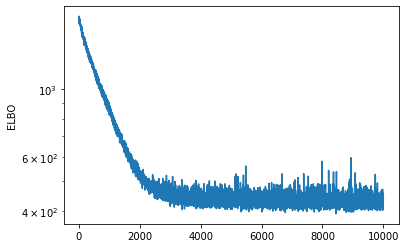

In [16]:
plt.semilogy(svi.loss)
plt.ylabel('ELBO')

In [17]:
svi.get_posterior_predictive(X, None, None, .1, return_sites=('f',))

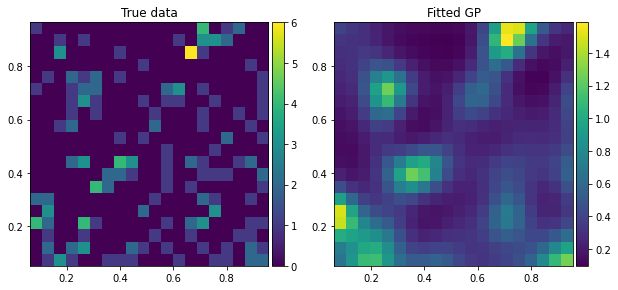

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(2*5, 4.5))

show_data(ax[0], X, y.reshape(20, -1).T, title='True data')
show_data(ax[1], X, jnp.exp(svi.mean('f', 'posterior_predictive')).reshape(-1, 20).T, title='Fitted GP')

# Conditional

In [19]:
Xnew = [jnp.linspace(0, 1, 100)[:,None], jnp.linspace(0, 1, 100)[:,None]]

In [21]:
cond = npg.LatentKronConditional(model_fixed_lengthscale, gp='f', num_samples=1)        

In [22]:
mu, var = cond.conditional_from_guide(guide_fixed_lengthscale, svi.params, X, y, Xnew, 0.1)

In [23]:
with npy.handlers.seed(rng_seed=34):
    x = npy.sample('pred', dist.MultivariateNormal(loc=mu, covariance_matrix=var))

Text(0.5, 1.0, 'Conditional')

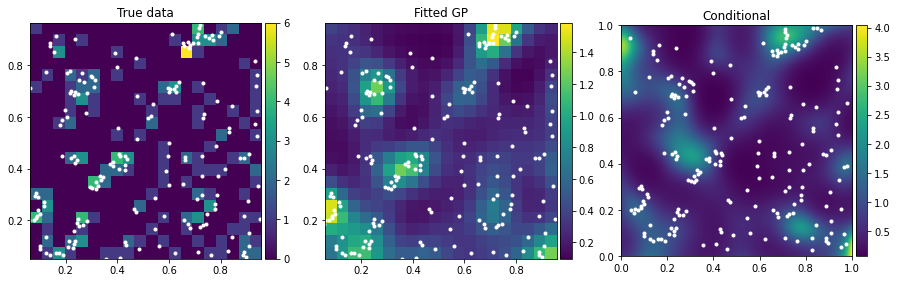

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(3*5, 4.5))

ax[0].plot(data['redwoodfull.x'], data['redwoodfull.y'], 'w.')
show_data(ax[0], X, y.reshape(20, -1).T, title='True data')

ax[1].plot(data['redwoodfull.x'], data['redwoodfull.y'], 'w.')
show_data(ax[1], X, jnp.exp(svi.mean('f', 'posterior_predictive')).reshape(-1, 20).T, title='Fitted GP')


im = ax[2].imshow(np.exp(x.mean(0).reshape(-1, 100).T), origin='lower', cmap='viridis', extent=(0,1,0,1))
ax[2].plot(data['redwoodfull.x'], data['redwoodfull.y'], 'w.')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[2].set_title('Conditional')